# ショックを含む画像の潜在ベクトルの分布を見る

In [1]:
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import random
# import seaborn as sns
# sns.set(font='IPAexGothic')
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial import distance
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/lib/")

In [3]:
from vae_preprocess import dataset2d, dataset1d
# import vae_model
# importlib.reload(vae_model)
from vae_models import ConvAE, ConvAE_2dim, DenseAE_2dim, ConvVAE, DenseVAE

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
data_pkls = "../data_pkls/"
pkl_files = [data_pkls + "imgs128_1.pkl", data_pkls + "imgs128_2.pkl", data_pkls + "imgs128_3.pkl"]
dataset1 = dataset1d(pkl_files)
dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=1, shuffle=False, drop_last=False)
#dataset2 = dataset2d(pkl_files)
#dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False, drop_last=False)

In [9]:
dates = None
with open(data_pkls + "dates.pkl", "rb") as pkl:
    dates = pickle.load(pkl)
print(len(dates))

19154


In [10]:
# img_size = dataset2[0].shape[1]
# print(dataset2[0].shape)
# print(img_size)

## DenseVAEの潜在ベクトル抽出

In [11]:
img_size = 128
print(dataset1[0].shape)
print(img_size)

torch.Size([16384])
128


In [12]:
model = DenseVAE(img_size)
model.load_state_dict(torch.load("../model_pths/DenseVAE.pth"))
model.eval()
model.to(device)

DenseVAE(
  (linear1): Linear(in_features=16384, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear_mean): Linear(in_features=1024, out_features=64, bias=True)
  (linear_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (dec_linear3): Linear(in_features=64, out_features=1024, bias=True)
  (dec_linear2): Linear(in_features=1024, out_features=4096, bias=True)
  (dec_linear1): Linear(in_features=4096, out_features=16384, bias=True)
)

In [14]:
orig_hidden_vecs = []
orig_hidden_mus = []
with torch.no_grad():
    for i, (date, batch_imgs) in enumerate(zip(dates, dataloader1)):
        mu, logvar = model.encoder(batch_imgs)
        # print(mu.shape, logvar.shape)
        orig_hidden_mus.append(mu.to("cpu").numpy())
        z = model.reparameterize(mu, logvar)
        # print(z.shape)
        z = z.to("cpu").numpy()
        orig_hidden_vecs.append(z)
orig_hidden_vecs = np.array(orig_hidden_vecs)
orig_hidden_mus = np.array(orig_hidden_mus)

In [15]:
print(orig_hidden_vecs.shape)
print(orig_hidden_mus.shape)

(19154, 1, 64)
(19154, 1, 64)


In [16]:
hidden_vecs = orig_hidden_vecs.reshape(19154, 64)
hidden_mus = orig_hidden_mus.reshape(19154, 64)
print(hidden_vecs.shape)
print(hidden_mus.shape)

(19154, 64)
(19154, 64)


In [17]:
with open(data_pkls + "hidden_vecs64_densevae.pkl", "wb") as f:
    pickle.dump(hidden_vecs, f)

In [18]:
with open(data_pkls + "hidden_mus64_densevae.pkl", "wb") as f:
    pickle.dump(hidden_mus, f)

In [19]:
num_clusters = 1000
clustering = KMeans(n_clusters=num_clusters, random_state=10).fit(hidden_mus)
labels = clustering.labels_

In [20]:
pkl_labels = data_pkls + "labels" + str(num_clusters) +  "_densevae" + ".pkl"

In [21]:
with open(pkl_labels, "wb") as f:
    pickle.dump(labels, f)

In [76]:
def imshow(dataset, dates, poses, model = None, device = "cpu", figsize=(15.0, 15.0)):
    data_type = 1 if len(dataset[0].shape) == 1 else 2
    plt.clf()
    fig = plt.figure(figsize=figsize)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(bottom=False, left=False, right=False, top=False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    for i, pos in enumerate(poses):
        ax = fig.add_subplot(np.ceil(np.sqrt(len(poses))).astype("int64"), np.ceil(np.sqrt(len(poses))).astype("int64"), i + 1)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax.set_title(dates[pos])
        if model is None:
            if data_type == 1:
                ax.imshow(dataset[pos].to("cpu").reshape(128,128), cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            else:
                ax.imshow(dataset[pos][0].to("cpu"), cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
        else:
            with torch.no_grad():
                output_img, _, _ = model(dataset[pos].unsqueeze(0))
                if data_type == 1:
                    ax.imshow(output_img.to("cpu").reshape(128,128), cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
                else:
                    ax.imshow(output_img.to("cpu")[0,0], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
    fig.tight_layout()
    plt.show()

In [51]:
with open(pkl_labels, "rb") as f:
    labels = pickle.load(f)

In [52]:
v_label = 50

In [53]:
np.where(labels==v_label)

(array([ 4129,  4153,  6045, 10031, 13539, 16144, 16145, 16146, 16147,
        16148, 16149, 16150, 17987, 17988, 17990, 17991, 17992]),)

In [54]:
np.where(labels==v_label)[0].shape

(17,)

<Figure size 432x288 with 0 Axes>

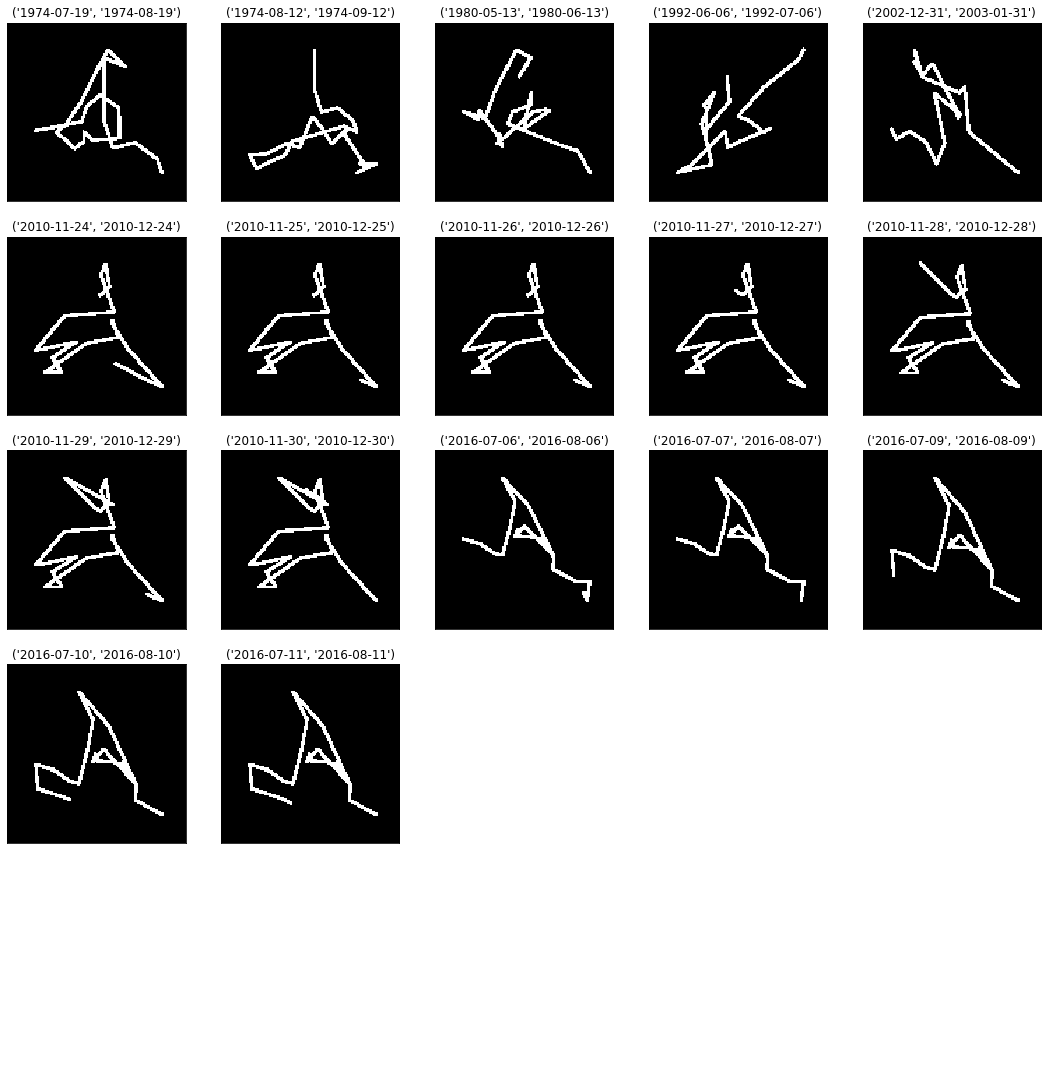

In [55]:
imshow(dataset2, dates, np.where(labels==v_label)[0])

<Figure size 432x288 with 0 Axes>

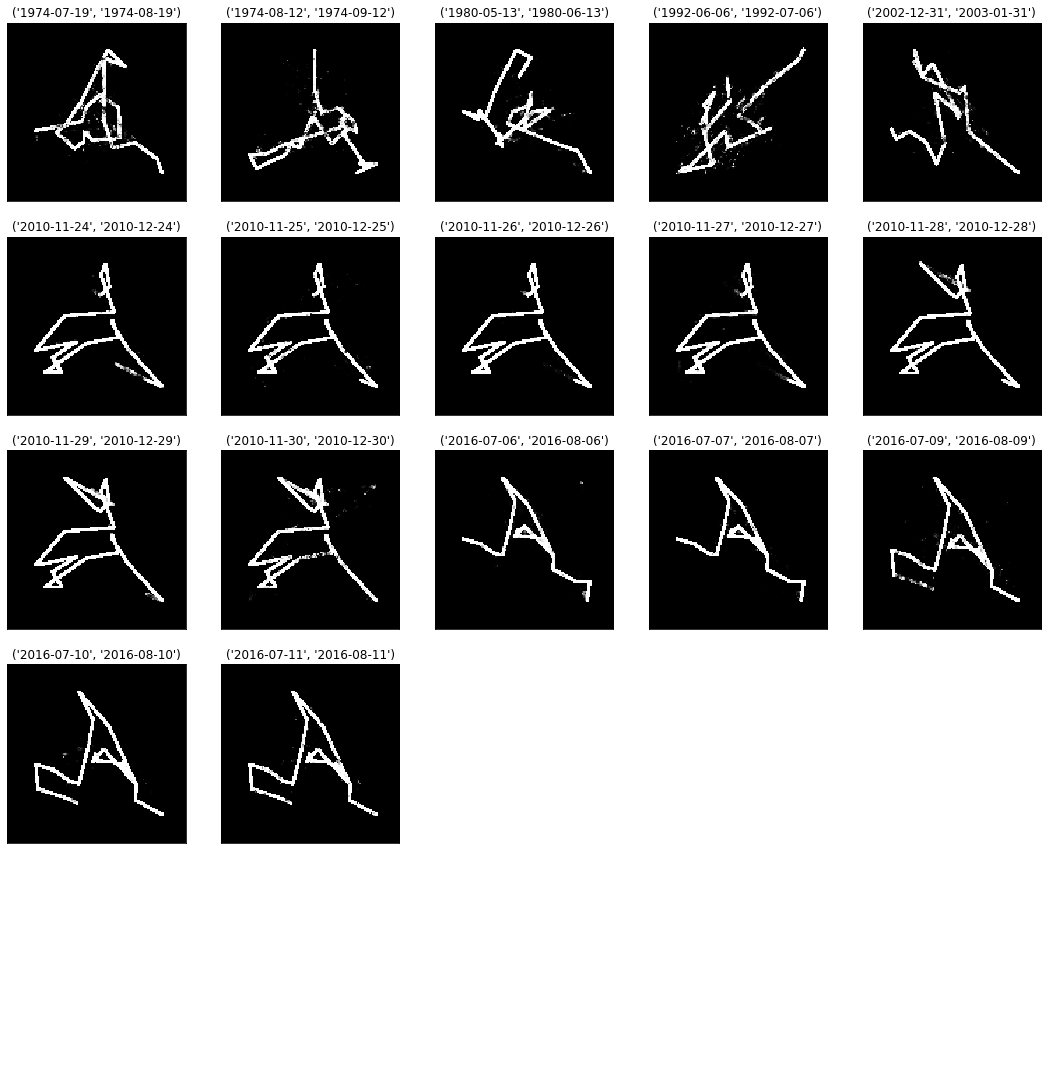

In [56]:
imshow(dataset1, dates, np.where(labels==v_label)[0], model=model)

## 日付が近いものを除外したい

In [57]:
num_clusters = 100
s_clustering = KMeans(n_clusters=num_clusters, random_state=10).fit(hidden_mus[::22])
s_labels = s_clustering.labels_

In [58]:
indices = np.array(list(range(19154))[::22])

In [59]:
np.where(s_labels==v_label)[0]

array([ 18, 400, 505])

In [60]:
poses = indices[np.where(s_labels==v_label)[0]]

<Figure size 432x288 with 0 Axes>

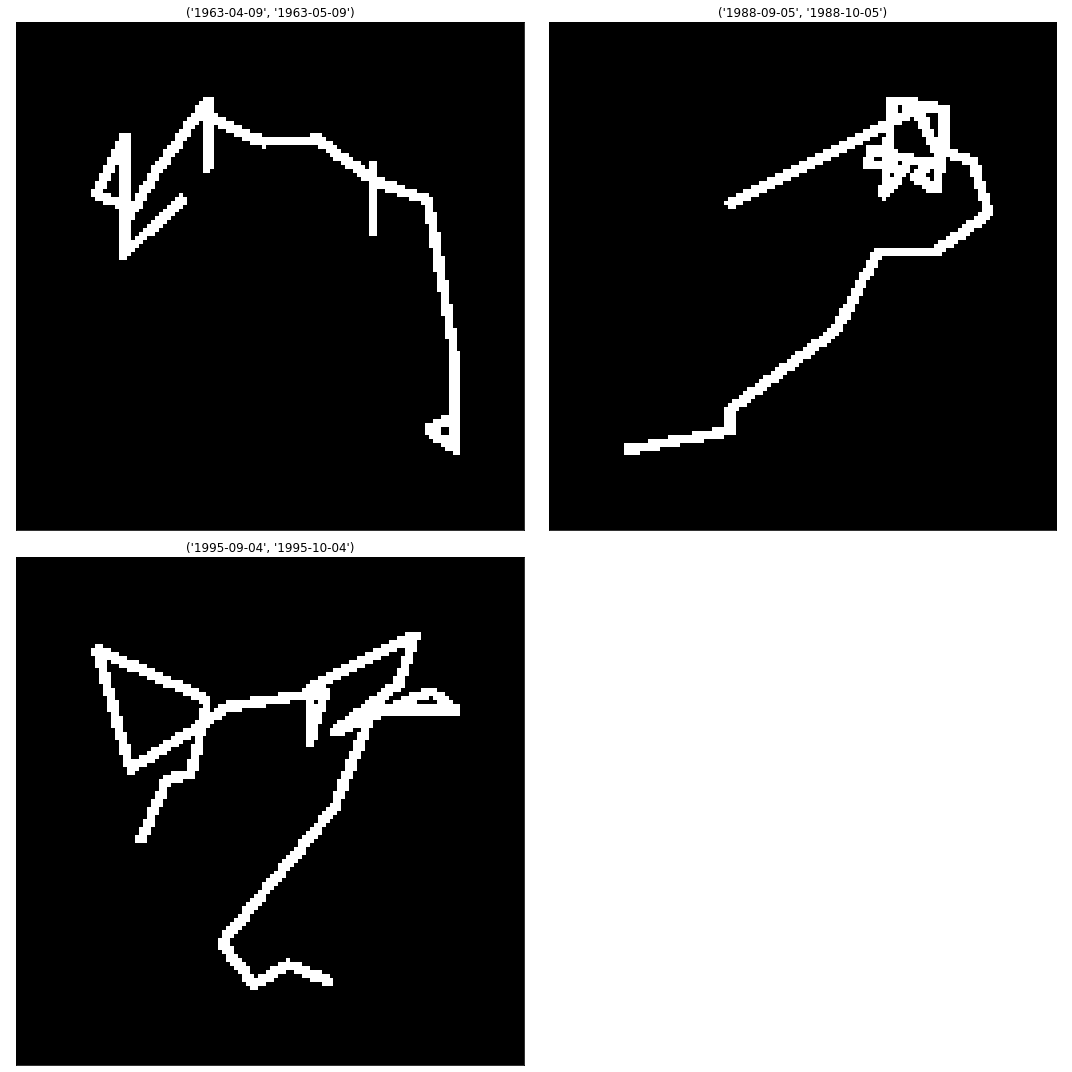

In [61]:
imshow(dataset2, dates, poses)

## 最も近いものを取ってくる

In [62]:
import heapq
class priority_queue:
    def __init__(self):
        self.key = lambda item: item[0] #アイテムの優先順位を指定
        self.index = 0
        self.data = []

    def push(self, item):
        heapq.heappush(self.data, (self.key(item), self.index, item))
        self.index += 1

    def pop(self):
        return heapq.heappop(self.data)[1]

In [67]:
def get_nearest(pos, hidden_vecs, n = 10):
    t_vec = hidden_vecs[pos]
    pq = priority_queue()
    for i, vec in enumerate(hidden_vecs):
        dist = distance.euclidean(t_vec, vec)
        pq.push([dist, i])
    n_poses = []
    for i in range(n + 1):
        n_poses.append(pq.pop())
    return n_poses[1:]

In [81]:
indices

array([    0,    22,    44,    66,    88,   110,   132,   154,   176,
         198,   220,   242,   264,   286,   308,   330,   352,   374,
         396,   418,   440,   462,   484,   506,   528,   550,   572,
         594,   616,   638,   660,   682,   704,   726,   748,   770,
         792,   814,   836,   858,   880,   902,   924,   946,   968,
         990,  1012,  1034,  1056,  1078,  1100,  1122,  1144,  1166,
        1188,  1210,  1232,  1254,  1276,  1298,  1320,  1342,  1364,
        1386,  1408,  1430,  1452,  1474,  1496,  1518,  1540,  1562,
        1584,  1606,  1628,  1650,  1672,  1694,  1716,  1738,  1760,
        1782,  1804,  1826,  1848,  1870,  1892,  1914,  1936,  1958,
        1980,  2002,  2024,  2046,  2068,  2090,  2112,  2134,  2156,
        2178,  2200,  2222,  2244,  2266,  2288,  2310,  2332,  2354,
        2376,  2398,  2420,  2442,  2464,  2486,  2508,  2530,  2552,
        2574,  2596,  2618,  2640,  2662,  2684,  2706,  2728,  2750,
        2772,  2794,

In [92]:
p = 500
pos = indices[p]
n = 16

/home/u00257/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

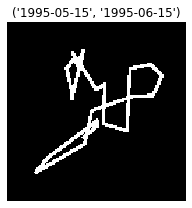

In [89]:
imshow(dataset2, dates, [pos], figsize = (3,3))

[10999, 10998, 11001, 11002, 10997, 10994, 10996, 10995, 11004, 10225, 11003, 6521, 7665, 10227, 10226, 6520]


<Figure size 432x288 with 0 Axes>

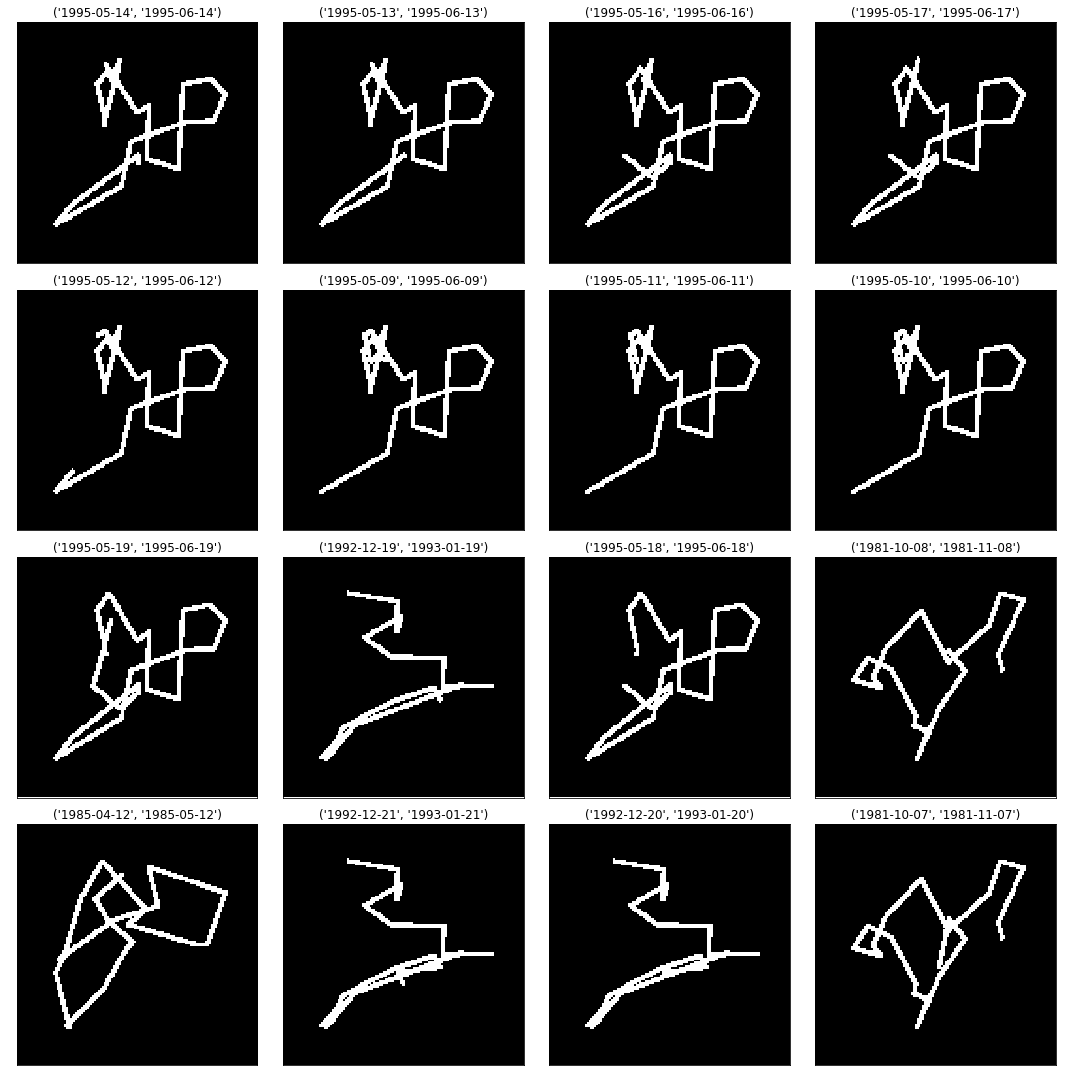

In [90]:
poses = get_nearest(pos, hidden_mus, n)
print(poses)
imshow(dataset2, dates, poses)

[12342 18062  9482  5214  4070  2816  9438 10670  8822 14542 12782  6842
  7502 13860  8954  6974]


<Figure size 432x288 with 0 Axes>

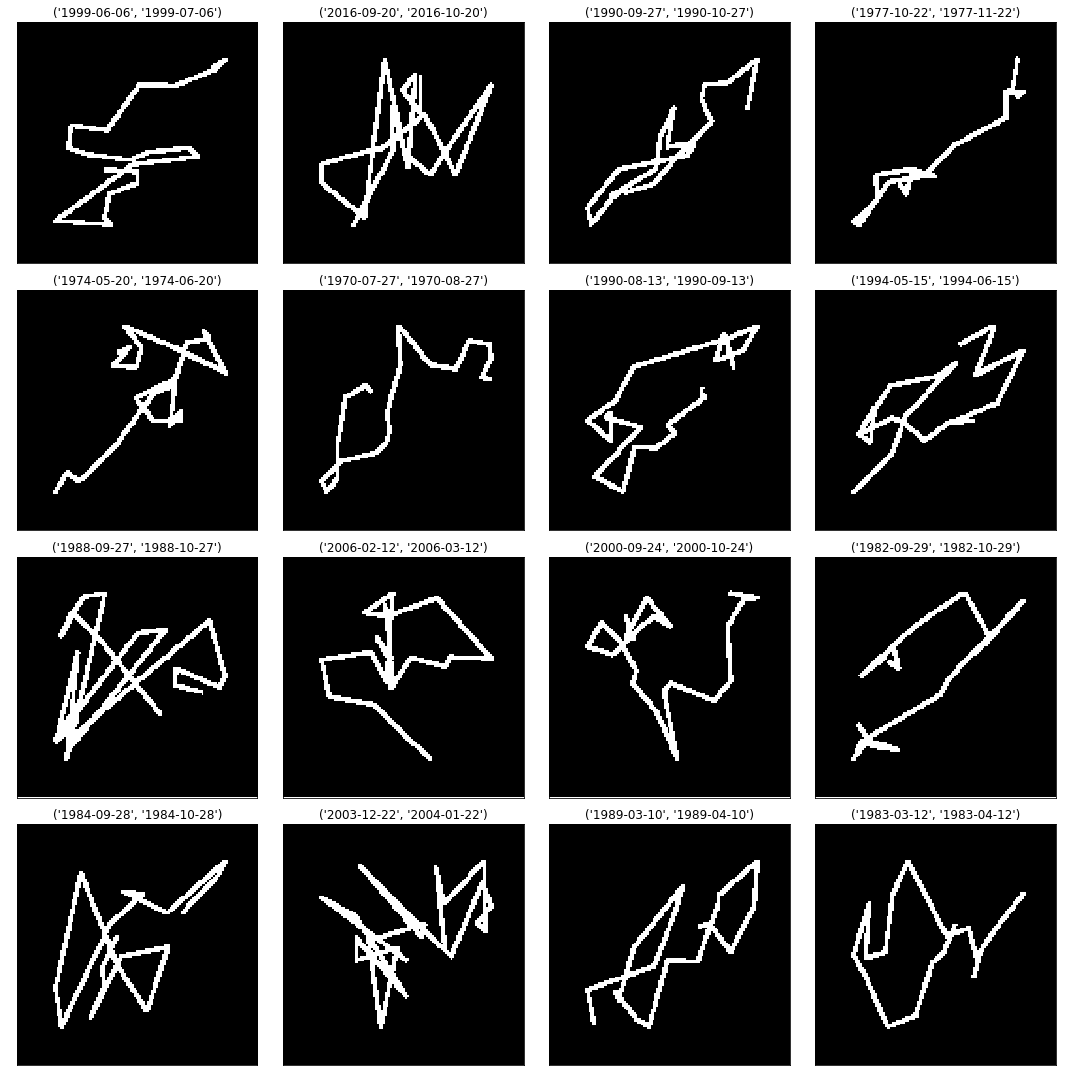

In [96]:
ps = get_nearest(p, hidden_mus[indices], n)
print(indices[ps])
imshow(dataset2, dates, indices[ps])

## 絶対位置をどうにかしたいよね

In [ ]:
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'vae_analysis.ipynb'])